<a href="https://colab.research.google.com/github/shubhamt2897/DL_BB/blob/main/DL_Bounding_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch torchvision
!pip install numpy matplotlib albumentations kornia open3d gdown



In [ ]:
# Step 2: Configure Git
!git config --global user.email "sp.tangadpalliwar@stud.fh-sm.de "  # Replace with your email
!git config --global user.name "shubhamt2897"

In [ ]:
!pip install gdown


In [ ]:
import os

dataset_path = "/content/dl_challenge"
print(os.listdir(dataset_path))  # List available files/folders


In [ ]:

!gdown "https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb"

Downloading...
From (original): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb
From (redirected): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb&confirm=t&uuid=3b9443b1-1a4e-4b9b-a444-af619f5ab314
To: /content/dl_challenge.tar.xz
100% 2.44G/2.44G [00:30<00:00, 78.8MB/s]


In [9]:
# Extract the downloaded dataset
!tar -xf /content/dl_challenge.tar.xz -C /content/

# Verify the dataset structure
import os
print("Dataset contents:", os.listdir("/content/dl_challenge"))

Dataset contents: ['9a7caa9b-9915-11ee-9103-bbb8eae05561', '889a9fb6-9915-11ee-9103-bbb8eae05561', '94855ef2-9915-11ee-9103-bbb8eae05561', '936fee3e-9915-11ee-9103-bbb8eae05561', '922c1c96-9915-11ee-9103-bbb8eae05561', 'a1c1d8c6-9915-11ee-9103-bbb8eae05561', 'a0818ba9-9915-11ee-9103-bbb8eae05561', 'a0818ba4-9915-11ee-9103-bbb8eae05561', '8fc581d3-9915-11ee-9103-bbb8eae05561', '9ce28681-9915-11ee-9103-bbb8eae05561', '8c39418c-9915-11ee-9103-bbb8eae05561', 'a0818baa-9915-11ee-9103-bbb8eae05561', '859074c5-9915-11ee-9103-bbb8eae05561', '8c394190-9915-11ee-9103-bbb8eae05561', '889a9fb5-9915-11ee-9103-bbb8eae05561', '983022a8-9915-11ee-9103-bbb8eae05561', '8fc581d4-9915-11ee-9103-bbb8eae05561', '94855ef5-9915-11ee-9103-bbb8eae05561', '9ce28687-9915-11ee-9103-bbb8eae05561', '9a7caa9f-9915-11ee-9103-bbb8eae05561', '9bccdb81-9915-11ee-9103-bbb8eae05561', '8b061a90-9915-11ee-9103-bbb8eae05561', '95c679cc-9915-11ee-9103-bbb8eae05561', '983022ad-9915-11ee-9103-bbb8eae05561', '889a9fb9-9915-11ee-9

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [24]:
class BBox3DDataset(Dataset):
    """
    Dataset class for 3D BBox prediction
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = sorted([f for f in os.listdir(root_dir)
                             if os.path.isdir(os.path.join(root_dir, f))])
        print(f"Found {len(self.samples)} samples")

        # Find the maximum number of bounding boxes across all samples
        self.max_bboxes = self.find_max_bboxes()

    def __len__(self):
        return len(self.samples)

    def find_max_bboxes(self):
        """Finds the maximum number of bounding boxes in a sample"""
        max_bboxes = 0
        for sample_dir in [os.path.join(self.root_dir, s) for s in self.samples]:
            bbox_path = os.path.join(sample_dir, 'bbox3d.npy')
            bbox = np.load(bbox_path)
            max_bboxes = max(max_bboxes, bbox.shape[0])
        return max_bboxes

    def __getitem__(self, idx):
        sample_dir = os.path.join(self.root_dir, self.samples[idx])

        # Load RGB image
        rgb_path = os.path.join(sample_dir, 'rgb.jpg')
        image = cv2.imread(rgb_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load 3D bounding box and pad if necessary
        bbox_path = os.path.join(sample_dir, 'bbox3d.npy')
        bbox = np.load(bbox_path)
        bbox = self.pad_bbox(bbox)  # Pad bounding boxes to maximum size

        # Load point cloud
        pc_path = os.path.join(sample_dir, 'pc.npy')
        pointcloud = np.load(pc_path)

        # Load instance mask
        mask_path = os.path.join(sample_dir, 'mask.npy')
        mask = np.load(mask_path)

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'bbox3d': torch.FloatTensor(bbox),
            'pointcloud': torch.FloatTensor(pointcloud),
            'mask': torch.FloatTensor(mask)
        }

    def pad_bbox(self, bbox):
        """Pads the bounding box array with zeros to have a uniform shape"""
        num_bboxes = bbox.shape[0]
        padding_size = self.max_bboxes - num_bboxes
        if padding_size > 0:
            padding = np.zeros((padding_size, 8, 3))  # Pad with zeros
            bbox = np.concatenate([bbox, padding], axis=0)
        return bbox

In [25]:
class BBox3DPredictor(nn.Module):
    def __init__(self, num_bbox_params=9*8*3):
        super(BBox3DPredictor, self).__init__()

        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=True)

        # Remove the last layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=2048, nhead=8)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=6)

        # Prediction head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_bbox_params)
        )

    def forward(self, x):
        x = self.backbone(x)

        # Reshape for transformer
        B, C, H, W = x.shape
        x = x.flatten(2).permute(2, 0, 1)

        # Apply transformer
        x = self.transformer(x)

        # Pool and predict
        x = x.permute(1, 2, 0).view(B, C, H, W)
        x = self.head(x)

        return x.view(-1, 9, 8, 3)

In [26]:
class BBox3DLoss(nn.Module):
    def __init__(self):
        super(BBox3DLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='mean')

    def forward(self, pred, target):
        return self.mse(pred, target)

In [27]:
def visualize_3d_bbox(ax, bbox, color='r'):
    """Visualize a 3D bounding box"""
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Connecting edges
    ]

    for (i, j) in edges:
        ax.plot3D(
            [bbox[i, 0], bbox[j, 0]],
            [bbox[i, 1], bbox[j, 1]],
            [bbox[i, 2], bbox[j, 2]],
            color=color
        )

def visualize_sample(sample, predictions=None):
    """Visualize a sample with ground truth and predictions"""
    fig = plt.figure(figsize=(20, 10))

    # RGB Image
    ax1 = fig.add_subplot(231)
    img = sample['image']
    if torch.is_tensor(img):
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
    ax1.imshow(img)
    ax1.set_title('RGB Image')
    ax1.axis('off')

    # Instance Mask
    ax2 = fig.add_subplot(232)
    mask = sample['mask'][0].numpy()
    ax2.imshow(mask)
    ax2.set_title('Instance Mask')
    ax2.axis('off')

    # Point Cloud (Top View)
    ax3 = fig.add_subplot(233)
    pc = sample['pointcloud']
    if torch.is_tensor(pc):
        pc = pc.numpy()
    pc = pc.reshape(-1, 3)
    ax3.scatter(pc[:, 0], pc[:, 1], s=1, alpha=0.1)
    ax3.set_title('Point Cloud (Top View)')
    ax3.set_aspect('equal')

    # 3D Visualization
    ax4 = fig.add_subplot(234, projection='3d')
    ax4.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1, alpha=0.1)
    for bbox in sample['bbox3d']:
        if torch.is_tensor(bbox):
            bbox = bbox.numpy()
        visualize_3d_bbox(ax4, bbox, color='g')
    ax4.set_title('Ground Truth 3D BBox')

    if predictions is not None:
        ax5 = fig.add_subplot(235, projection='3d')
        ax5.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1, alpha=0.1)
        for bbox in predictions:
            if torch.is_tensor(bbox):
                bbox = bbox.numpy()
            visualize_3d_bbox(ax5, bbox, color='r')
        ax5.set_title('Predicted 3D BBox')

    plt.tight_layout()
    plt.show()

def plot_training_progress(train_losses, val_losses):
    """Plot training progress"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=10, device='cuda', visualize_every=5):
    model = model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0

        for i, batch in enumerate(train_loader):
            images = batch['image'].to(device)
            targets = batch['bbox3d'].to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            if i == 0 and epoch % visualize_every == 0:
                with torch.no_grad():
                    predictions = outputs[0].cpu()
                    sample = {k: v[0].cpu() for k, v in batch.items()}
                    visualize_sample(sample, predictions)

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                targets = batch['bbox3d'].to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')

        plot_training_progress(train_losses, val_losses)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, 'best_model.pth')
            print('Saved new best model')

    return train_losses, val_losses

Found 200 samples
Visualizing a random sample before training:


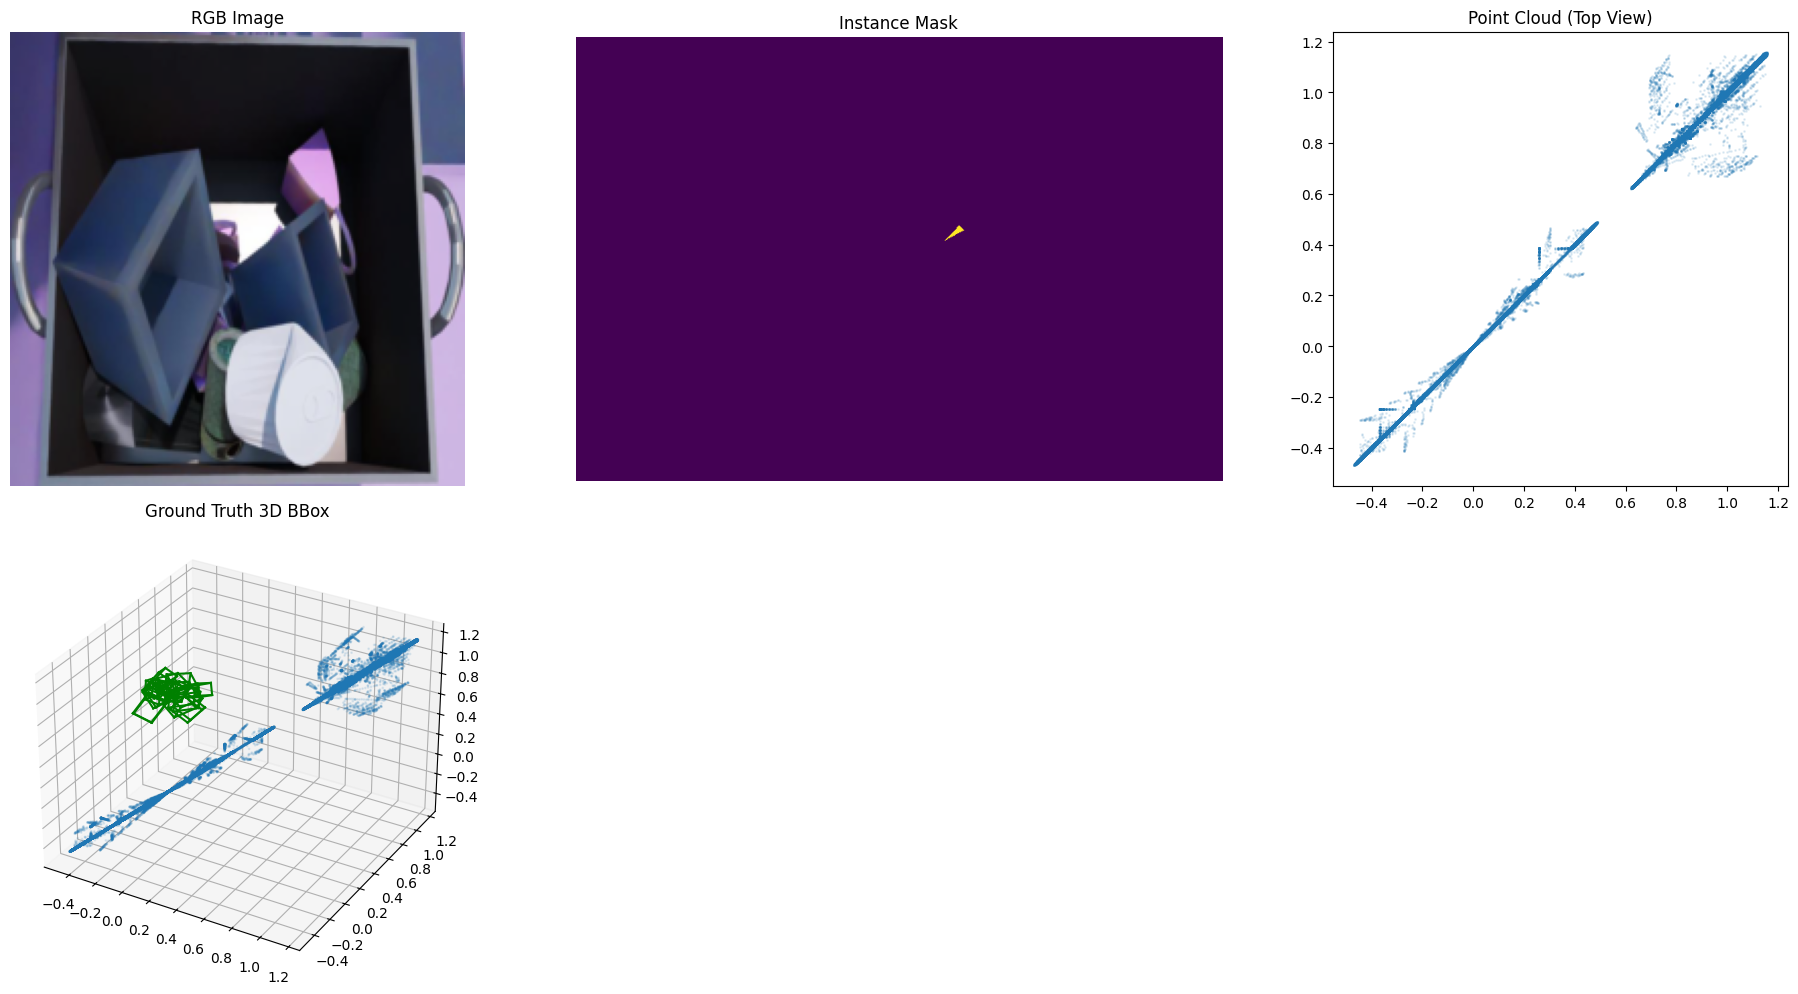

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Using device: cuda


RuntimeError: stack expects each tensor to be equal size, but got [3, 397, 442] at entry 0 and [3, 430, 649] at entry 1

In [31]:
# Set up transforms
# Set up transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), #Removed CenterCrop
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create dataset
dataset = BBox3DDataset('/content/dl_challenge', transform=transform)

# Visualize a random sample
print("Visualizing a random sample before training:")
visualize_sample(dataset[np.random.randint(len(dataset))])

# Create data loaders
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize model, loss, and optimizer
model = BBox3DPredictor()
criterion = BBox3DLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=10, device=device, visualize_every=2
)

# Export to ONNX
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, "bbox3d_predictor.onnx")
print("\nModel exported to ONNX format")